### Import basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set();

from ucimlrepo import fetch_ucirepo

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import f_classif, SelectKBest


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, r2_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.inspection import permutation_importance

from catboost import CatBoostClassifier

### Dataset

In [2]:
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
df = bank_marketing.data.features 
y = bank_marketing.data.targets 
  
# metadata 
print(bank_marketing.metadata) 
  
# variable information 
print(bank_marketing.variables) 


{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'title': 'A data-driven approach to predict the success of bank telemarketing'

In [3]:
df.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
30043,36,blue-collar,married,primary,no,347,no,no,cellular,4,feb,167,2,-1,0,NaN
9421,60,retired,married,primary,no,22018,no,no,NaN,6,jun,177,2,-1,0,NaN
42278,67,retired,married,secondary,no,1146,no,no,cellular,13,nov,259,1,92,2,failure
19774,55,retired,married,primary,no,2325,yes,yes,telephone,8,aug,87,7,-1,0,NaN
21405,48,blue-collar,married,primary,no,583,no,no,cellular,18,aug,260,8,-1,0,NaN


In [4]:
df.shape

(45211, 16)

## Dataset acquaintance

In [5]:
df.isna().sum()

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64

In [6]:
sum(df.isna().sum())

52124

In [7]:
df = df.fillna({'job': 'unknown', 'education': 'unknown', 'contact': 'unknown', 'poutcome': 'unknown'})

The fraction of '1' values in the dataset

In [8]:
# A2: 0.117
print(f'{y.value_counts().iloc[1] / len(y):.3f}')

0.117


In [9]:
df['y'] = y

In [10]:
def success_category(cat1: str = '', cat2: str = ''):
    categ_rate = dict()
    if cat2:
        for col1 in df[cat1].unique():
            for col2 in df[cat2].unique():
                categ_rate[f'{col1, col2}'] = len(df.query(f'(y == "yes") and ({cat1} == "{col1}") and ({cat2} == "{col2}")')) / len(df.query(f'({cat1} == "{col1}") and ({cat2} == "{col2}")'))
    else:
        for col1 in df[cat1].unique():
            categ_rate[f'{col1}'] = len(df.query(f'(y == "yes") and ({cat1} == "{col1}")')) / len(df.query(f'({cat1} == "{col1}")'))
    
    return {k: round(v, 3) for k, v in sorted(categ_rate.items(), key=lambda item: item[1], reverse=True)}

In [11]:
success_cat_32 = success_category('contact')
success_cat_32

{'cellular': 0.149, 'telephone': 0.134, 'unknown': 0.041}

In [12]:
success_cat_34 = success_category('job')
success_cat_34

{'student': 0.287,
 'retired': 0.228,
 'unemployed': 0.155,
 'management': 0.138,
 'admin.': 0.122,
 'self-employed': 0.118,
 'unknown': 0.118,
 'technician': 0.111,
 'services': 0.089,
 'housemaid': 0.088,
 'entrepreneur': 0.083,
 'blue-collar': 0.073}

In [13]:
success_cat_35 = success_category('marital', 'job')
success_cat_35

{"('single', 'student')": 0.294,
 "('divorced', 'retired')": 0.285,
 "('married', 'retired')": 0.221,
 "('single', 'unemployed')": 0.195,
 "('single', 'self-employed')": 0.193,
 "('married', 'student')": 0.185,
 "('single', 'unknown')": 0.176,
 "('single', 'housemaid')": 0.167,
 "('divorced', 'student')": 0.167,
 "('single', 'management')": 0.162,
 "('divorced', 'unemployed')": 0.158,
 "('divorced', 'self-employed')": 0.157,
 "('single', 'admin.')": 0.136,
 "('married', 'unemployed')": 0.133,
 "('single', 'technician')": 0.132,
 "('divorced', 'management')": 0.128,
 "('married', 'management')": 0.126,
 "('single', 'retired')": 0.12,
 "('divorced', 'admin.')": 0.12,
 "('single', 'services')": 0.118,
 "('married', 'admin.')": 0.114,
 "('single', 'entrepreneur')": 0.113,
 "('single', 'blue-collar')": 0.106,
 "('married', 'unknown')": 0.103,
 "('married', 'technician')": 0.103,
 "('divorced', 'housemaid')": 0.098,
 "('divorced', 'services')": 0.091,
 "('divorced', 'entrepreneur')": 0.084,


Map binary columns to 0 / 1 values (1 corresponds to yes). Do the same for the target variable y.

In [14]:
success_cat_41_1 = success_category(cat1='housing')
print(f'Housing: {success_cat_41_1}')
success_cat_41_2 = success_category(cat1='loan')
print(f'Loan: {success_cat_41_2}')

Housing: {'no': 0.167, 'yes': 0.077}
Loan: {'no': 0.127, 'yes': 0.067}


In [15]:
def encoder(data: pd.DataFrame, features: list, encoder=LabelEncoder()):
    for col in features:
        data[col] = encoder.fit_transform(data[[col]])

In [16]:
encoder(df, ['y'])

c:\Users\79179\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
encoder(df, ['default', 'housing', 'loan'])

c:\Users\79179\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\79179\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\79179\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
df.query('housing == 1')['age'].describe()

count    25130.000000
mean        39.175288
std          8.926807
min         20.000000
25%         32.000000
50%         38.000000
75%         45.000000
max         78.000000
Name: age, dtype: float64

-----

### Visualize the feature `age` for success and fail cases

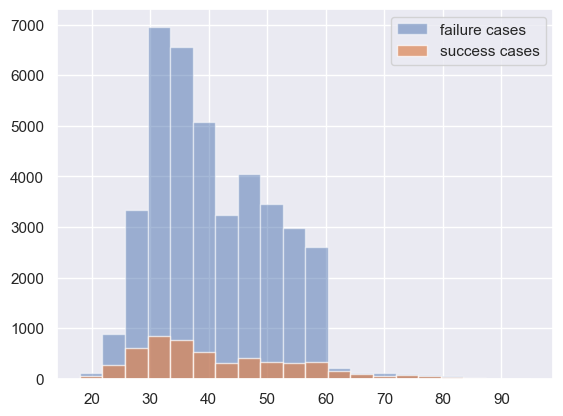

In [19]:
plt.hist(df.query('y == 0')['age'], bins=20, label='failure cases', alpha=.5)
plt.hist(df.query('y == 1')['age'], bins=20, label='success cases', alpha=.7)
plt.legend()
plt.show()

### Visualize the feature `duration` for success and fail cases

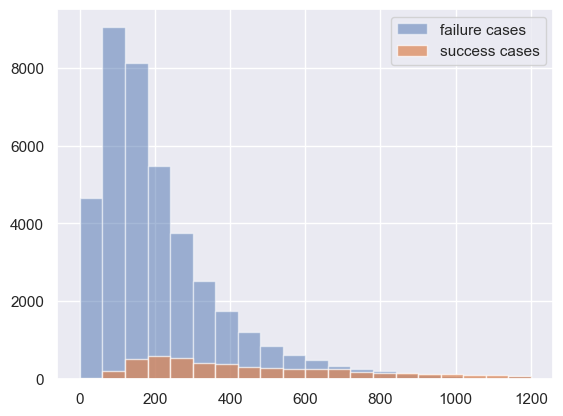

In [20]:
plt.hist(df.query('y == 0')['duration'], bins=20, label='failure cases', alpha=.5, range=[0, 1200])
plt.hist(df.query('y == 1')['duration'], bins=20, label='success cases', alpha=.7, range=[0, 1200])
plt.legend()
plt.show()

-----

In [21]:
print(f'List of numerical columns: {df.select_dtypes(include="int64").drop(["day_of_week"], axis=1).columns.tolist()}')
print(f'Number of numerical columns: {len(df.select_dtypes(include="int64").drop(["day_of_week"], axis=1).columns.tolist())}')

List of numerical columns: ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
Number of numerical columns: 6


Compute Pearson correlation coefficient

In [22]:
df.loc[:, ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'y']].corr()['y']

age         0.025155
balance     0.052838
duration    0.394521
campaign   -0.073172
pdays       0.103621
previous    0.093236
y           1.000000
Name: y, dtype: float64

#### Visualize dependency of numerical data with success

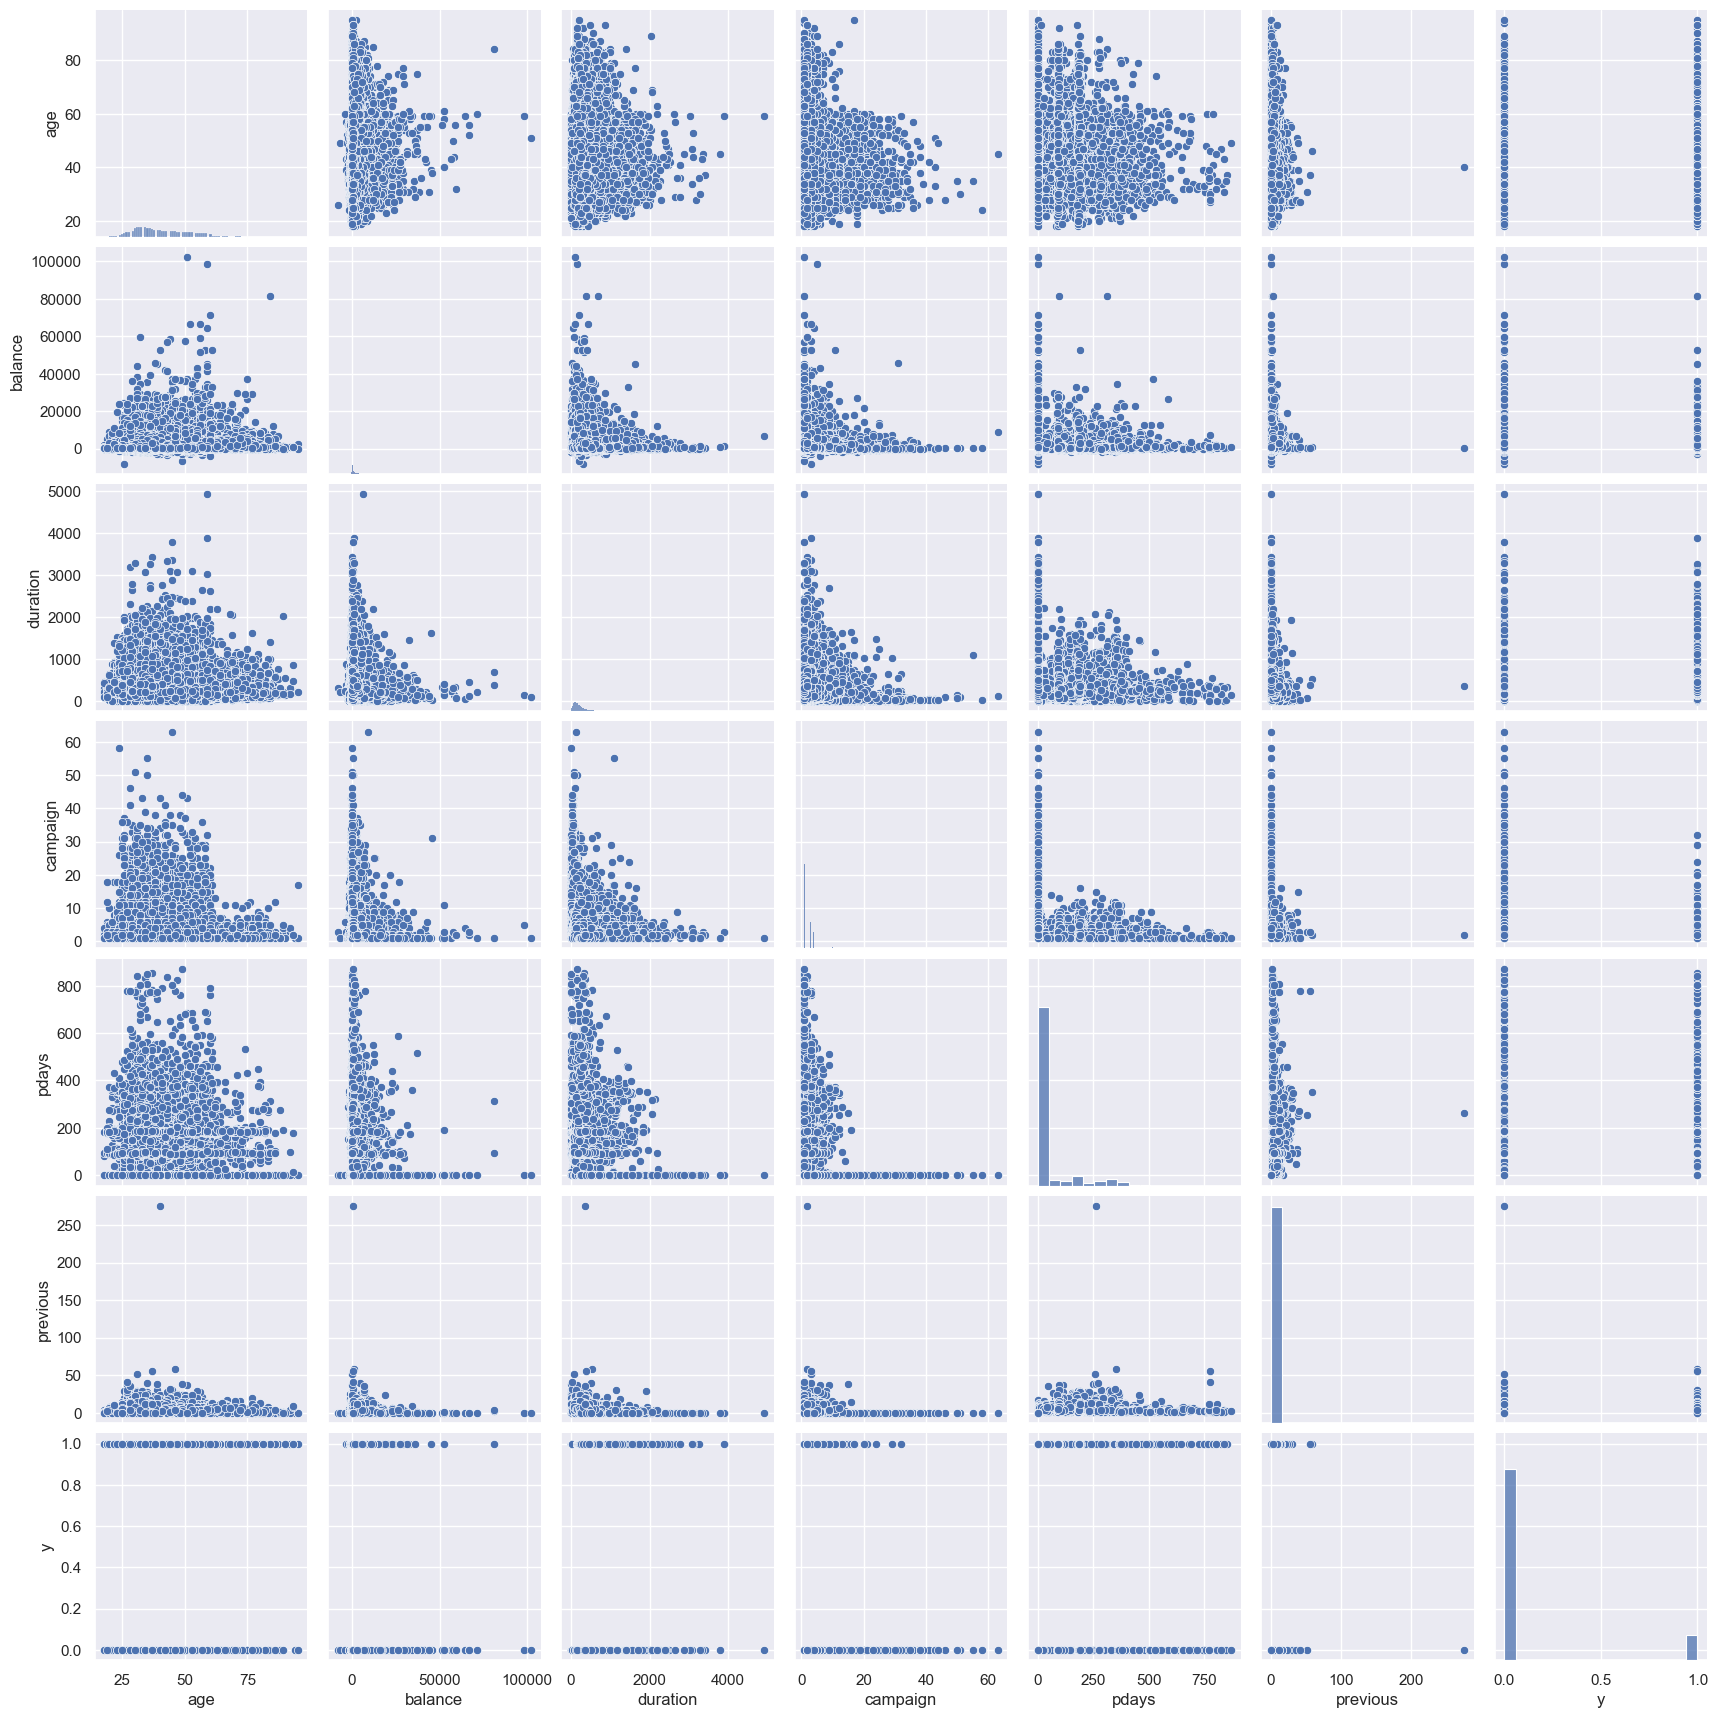

In [23]:
sns.pairplot(data=df.loc[:, ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'y']])

Lets' generate some more features that could be useful.

In [24]:
df['is_contacted'] = df['pdays'].apply(lambda x: 1 if x >= 0 else 0)

In [25]:
print(f'Number of people that were not contacted earlier: {df["is_contacted"].value_counts()[0]}')

Number of people that were not contacted earlier: 36954


------
-----
# Preprocessing

Drop the leaking column with target variable from the dataframe

In [26]:
df_for_model = df.drop(['y'], axis=1)
y_for_model = df['y']
print(f'Number of columns: {len(df_for_model.columns)}')
df_for_model.head()

Number of columns: 17


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,is_contacted
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0


Add one-hot labels for categorical columns

In [27]:
# TODO add one-hot labels and drop columns
pd.options.display.max_columns = 50
#encoder(df_for_model, features=['month'], encoder=LabelEncoder())
df_for_model = pd.get_dummies(df_for_model)
df_for_model.head() 

,age,default,balance,housing,loan,day_of_week,duration,campaign,pdays,previous,is_contacted,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,47,0,1506,1,0,5,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,33,0,1,0,0,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [28]:
print(f'Number of columns: {len(df_for_model.columns)}')

Number of columns: 49


Split the dataset without stratification

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_for_model, y_for_model, test_size=.2, random_state=42)

In [30]:
print(f'Number of successful deposit subscriptions in train set: {y_train.sum()}')

Number of successful deposit subscriptions in train set: 4198


Scale the numeric columns with standard scaler

In [31]:
scaler = StandardScaler()
X_train[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'day_of_week']] = scaler.fit_transform(X_train[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'day_of_week']])
X_test[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'day_of_week']] = scaler.transform(X_test[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'day_of_week']])

In [32]:
print(f'Median value in Duration field: {X_train.duration.median():.3f}')

Median value in Duration field: -0.299


### Estimate feature importance by Anova

In [33]:
f_statistics, p_value = f_classif(X_train, y_train)

In [34]:
feature_score = pd.DataFrame(f_statistics)
features = pd.DataFrame(X_train.columns)
feature_score = pd.concat([features, feature_score], axis=1)
feature_score.columns = ['Important Features', 'Score']
print(feature_score.nlargest(3, columns='Score'))

   Important Features        Score
6            duration  6622.108310
47   poutcome_success  3711.669817
10       is_contacted  1074.369155


------

## Logistic regression

In [35]:
Logistic_reg = LogisticRegression(penalty='l2', n_jobs=1)
logistic_reg_parameters = {'C': np.logspace(-2, 4, 7), 'max_iter': [400]}
grid_search_cv_log = GridSearchCV(Logistic_reg, logistic_reg_parameters, cv=5)

In [36]:
grid_search_cv_log.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=1),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'max_iter': [400]})

In [37]:
print(f'Optimal C for l2 regularization {grid_search_cv_log.best_params_["C"]}')

Optimal C for l2 regularization 1.0


In [38]:
Logistic_best_reg = grid_search_cv_log.best_estimator_
# Score using Logistic Regression with l2 penalty
print(f'Accuracy for train data {Logistic_best_reg.score(X=X_train, y=y_train):.3f}')
print(f'Accuracy for test data: {Logistic_best_reg.score(X=X_test, y=y_test):.3f}')

Accuracy for train data 0.903
Accuracy for test data: 0.899


In [39]:
Log_feature_importances = pd.DataFrame({'importance': permutation_importance(Logistic_best_reg, X_train, y_train)['importances_mean']}, index=list(X_train))
Log_feature_importances.sort_values('importance', ascending=False).iloc[:3, :]

,importance
duration,0.032117
poutcome_success,0.006492
contact_unknown,0.002289


In [40]:
y_pred_Logistic_train = Logistic_best_reg.predict_proba(X_train)
y_pred_Logistic_test = Logistic_best_reg.predict_proba(X_test)
print(f'ROC-AUC score for train: {roc_auc_score(y_train, y_pred_Logistic_train[:, 1]):.3f}')
print(f'ROC-AUC score for test: {roc_auc_score(y_test, y_pred_Logistic_test[:, 1]):.3f}')

ROC-AUC score for train: 0.909
ROC-AUC score for test: 0.905


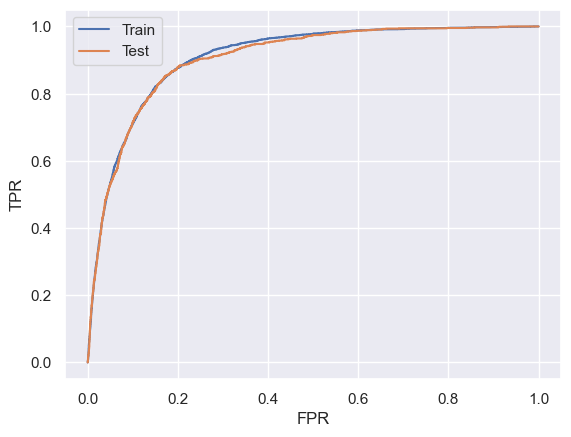

In [41]:
fpr_train, tpr_train, _train = roc_curve(y_train,  y_pred_Logistic_train[:, 1])
fpr_test, tpr_test, _test = roc_curve(y_test,  y_pred_Logistic_test[:, 1])

#create ROC curve
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

------

## Q17 Random forest

In [42]:
Forest_clf = RandomForestClassifier(n_jobs=1)
Forest_clf_parameters = {'max_depth': [5, 10, 15], 'n_estimators': [50, 100, 200]}
grid_search_cv_forest_clf = GridSearchCV(Forest_clf, Forest_clf_parameters, cv=5)
grid_search_cv_forest_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [50, 100, 200]})

In [43]:
print(f'Optimal depth: {grid_search_cv_forest_clf.best_params_["max_depth"]}')
print(f'Optimal number of trees: {grid_search_cv_forest_clf.best_params_["n_estimators"]}')

Optimal depth: 15
Optimal number of trees: 200


In [44]:
Forest_best_clf = grid_search_cv_forest_clf.best_estimator_
# Score using Random Forest Classifier
print(f'Accuracy for train data {Forest_best_clf.score(X=X_train, y=y_train):.3f}')
print(f'Accuracy for test data: {Forest_best_clf.score(X=X_test, y=y_test):.3f}')

Accuracy for train data 0.958
Accuracy for test data: 0.904


In [45]:
y_pred_forest_train = Forest_best_clf.predict_proba(X_train)
y_pred_forest_test = Forest_best_clf.predict_proba(X_test)
print(f'ROC-AUC score for train: {roc_auc_score(y_train, y_pred_forest_train[:, 1]):.3f}')
print(f'ROC-AUC score for test: {roc_auc_score(y_test, y_pred_forest_test[:, 1]):.3f}')

ROC-AUC score for train: 0.985
ROC-AUC score for test: 0.928


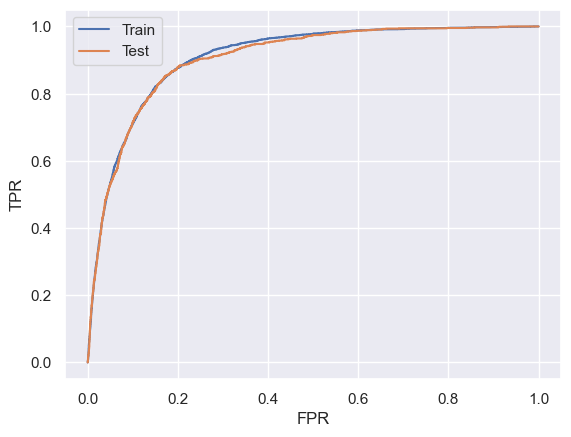

In [46]:
fpr_forest_train, tpr_forest_train, _train = roc_curve(y_train,  y_pred_Logistic_train[:, 1])
fpr_forest_test, tpr_forest_test, _test = roc_curve(y_test,  y_pred_Logistic_test[:, 1])

#create ROC curve
plt.plot(fpr_forest_train, tpr_forest_train, label='Train')
plt.plot(fpr_forest_test, tpr_forest_test, label='Test')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [47]:
precision_recall_table_forest = pd.DataFrame(precision_recall_curve(y_test, y_pred_forest_test[:, 1])).T.rename(columns={0: 'precision', 1: 'recall', 2: 'thresholds'})

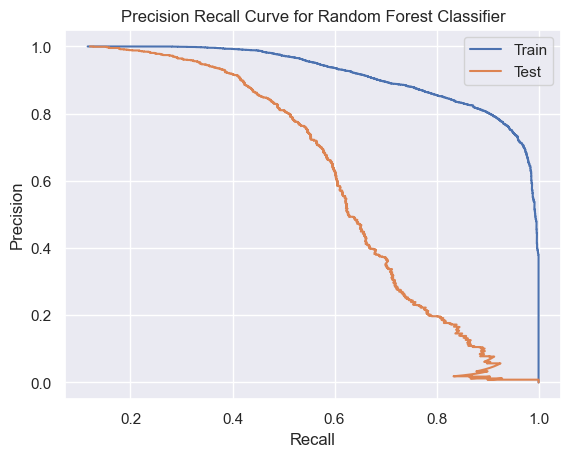

In [48]:
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_pred_forest_train[:, 1])
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred_forest_test[:, 1])
#create Precision-Recall curve
plt.plot(precision_train, recall_train, label='Train')
plt.plot(precision_test, recall_test, label='Test')
plt.title('Precision Recall Curve for Random Forest Classifier')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [49]:
print(f'The highest precision for recall > 0.5: {precision_recall_table_forest.query("recall > 0.5")["precision"].max():.3f}')

The highest precision for recall > 0.5: 0.628


In [50]:
print(f'Recall for binarization threshold=0.3: {precision_recall_table_forest.query("thresholds >= 0.3").iloc[0, 1]:.3f}')

Recall for binarization threshold=0.3: 0.706


In [51]:
Forest_feature_importances = pd.DataFrame({'importance': Forest_best_clf.feature_importances_}, index=list(X_test))
Forest_feature_importances.sort_values('importance', ascending=False).iloc[:3, :]

,importance
duration,0.315161
poutcome_success,0.077390
age,0.074378


-----

## Feature selection
Select **top-30** features (by random forest model). Train random forest again with the same parameters of grid search. 

In [52]:
X_train_top30 = X_train[Forest_feature_importances.sort_values('importance', ascending=False).reset_index().loc[0:29, 'index'].tolist()]
X_test_top30 = X_test[Forest_feature_importances.sort_values('importance', ascending=False).reset_index().loc[0:29, 'index'].tolist()]
X_train_top30.head()

,duration,poutcome_success,age,balance,day_of_week,pdays,housing,campaign,previous,month_mar,month_oct,poutcome_failure,month_apr,month_jun,contact_unknown,contact_cellular,month_sep,month_may,marital_married,is_contacted,education_tertiary,education_secondary,loan,month_aug,marital_single,poutcome_unknown,month_jul,job_technician,job_management,job_blue-collar
3344,-0.719756,0,0.006515,-0.169381,-0.098218,-0.411364,1,-0.565886,-0.244772,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1
17965,0.047138,0,0.759937,0.017848,1.703422,-0.411364,1,-0.245389,-0.244772,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,1,0,0
18299,-0.493970,0,0.100693,0.820681,1.823532,-0.411364,0,0.395606,-0.244772,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0
10221,0.459781,0,-0.370196,-0.489588,-0.578656,-0.411364,1,2.639088,-0.244772,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0
32192,0.027674,0,1.419181,0.706889,-0.098218,-0.411364,0,-0.245389,-0.244772,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1


In [53]:
grid_search_cv_forest_clf.fit(X_train_top30, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [50, 100, 200]})

In [54]:
Forest_best_clf_top30 = grid_search_cv_forest_clf.best_estimator_
# Score using Random Forest Classifier
print(f'Accuracy for train data {Forest_best_clf_top30.score(X=X_train_top30, y=y_train):.3f}')
print(f'Accuracy for test data: {Forest_best_clf_top30.score(X=X_test_top30, y=y_test):.3f}')

Accuracy for train data 0.965
Accuracy for test data: 0.903


In [55]:
Forest_feature_importances_top30 = pd.DataFrame({'importance': Forest_best_clf_top30.feature_importances_}, index=list(X_test_top30))
Forest_feature_importances_top30.sort_values('importance', ascending=False).iloc[:3, :]

,importance
duration,0.326804
age,0.088459
poutcome_success,0.082934


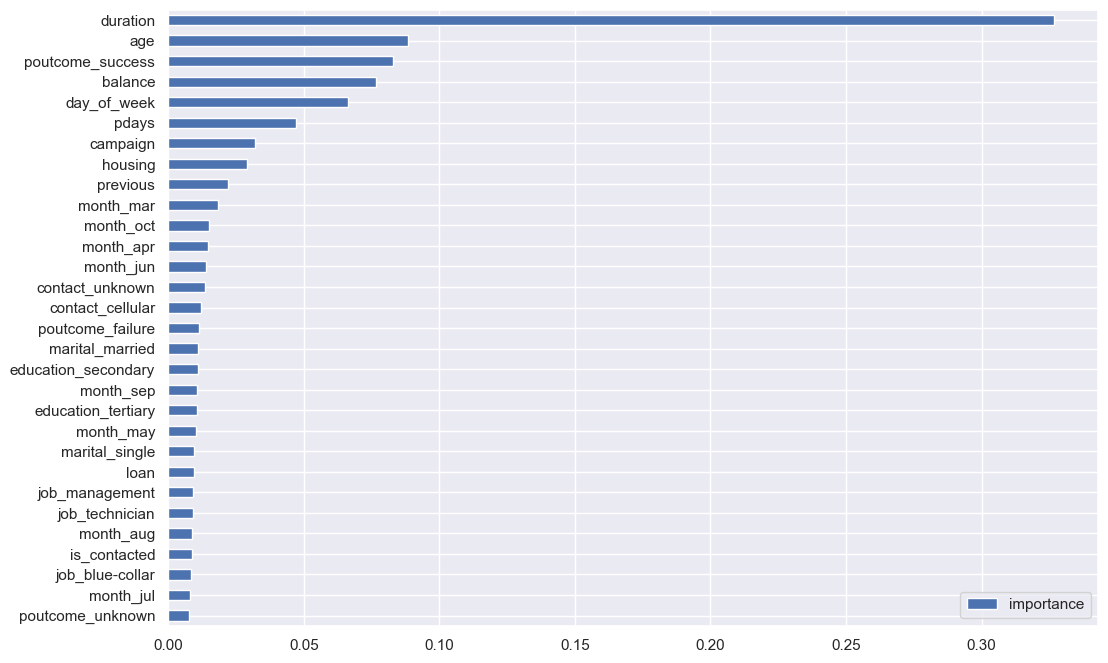

In [56]:
Forest_feature_importances_top30 = Forest_feature_importances_top30.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [57]:
y_pred_forest_train_top30 = Forest_best_clf_top30.predict_proba(X_train_top30)
y_pred_forest_test_top30 = Forest_best_clf_top30.predict_proba(X_test_top30)
print(f'ROC-AUC score for train: {roc_auc_score(y_train, y_pred_forest_train_top30[:, 1]):.3f}')
print(f'ROC-AUC score for test: {roc_auc_score(y_test, y_pred_forest_test_top30[:, 1]):.3f}')

ROC-AUC score for train: 0.986
ROC-AUC score for test: 0.925


In [58]:
print(f'F1 score for the model: {f1_score(y_test, Forest_best_clf_top30.predict(X_test_top30)):.3f}')

F1 score for the model: 0.485


------
## Analysis

Important features for Logistic regression: duration, poutcome_success, contact_unknown<br>
Important features for Random Forest Classifier: duration, poutcome_success, age<br>
Important features for Random Forest Classifier (top30): duration, age, balance<br>

The most important feature for this model is 'duration'. It means that this variable has highest contribution and usefulness for a prediction. Other variables (poutcome_success, age, contact_unknown, balance) contributes lower than 'duration' variable and have approximately the same importance. That is why for different methods there could be slightly different important features, but, overall, their contribution is almost the same.

----

## Build the stronger model

---

In [59]:
def seasons_split(x):
    if x in ['dec', 'jan', 'feb']:
        return 'winter'
    elif x in['sep', 'oct', 'nov']:
        return 'autumn'
    elif x in ['jun', 'jul', 'aug']:
        return 'summer'
    else:
        return 'spring'

def age_split(x):
    if x >= 18 and x <= 27:
        return 'youth'
    elif x > 27 and x <= 44:
        return 'adult'
    elif x > 44 and x <= 60:
        return 'old'
    else:
        return 'senior'

In [60]:
df_for_new_model = df
df_for_new_model['seasons'] = (df_for_new_model['month']).apply(seasons_split)
df_for_new_model['age_group'] = (df_for_new_model['age']).apply(age_split)
df_for_new_model = df_for_new_model.drop(['month', 'age'], axis=1)
df_for_new_model.head()

,job,marital,education,default,balance,housing,loan,contact,day_of_week,duration,campaign,pdays,previous,poutcome,y,is_contacted,seasons,age_group
0,management,married,tertiary,0,2143,1,0,unknown,5,261,1,-1,0,unknown,0,0,spring,old
1,technician,single,secondary,0,29,1,0,unknown,5,151,1,-1,0,unknown,0,0,spring,adult
2,entrepreneur,married,secondary,0,2,1,1,unknown,5,76,1,-1,0,unknown,0,0,spring,adult
3,blue-collar,married,unknown,0,1506,1,0,unknown,5,92,1,-1,0,unknown,0,0,spring,old
4,unknown,single,unknown,0,1,0,0,unknown,5,198,1,-1,0,unknown,0,0,spring,adult


In [61]:
df_for_strong_model = pd.get_dummies(df_for_new_model)

y_for_strong_model = y
encoder(data=y_for_strong_model, features=['y'])

print(f'Number of columns: {len(df_for_model.columns)}')
df_for_strong_model.head()

Number of columns: 49


c:\Users\79179\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\79179\AppData\Local\Temp\ipykernel_36020\1495748864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = encoder.fit_transform(data[[col]])


,default,balance,housing,loan,day_of_week,duration,campaign,pdays,previous,y,is_contacted,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,seasons_autumn,seasons_spring,seasons_summer,seasons_winter,age_group_adult,age_group_old,age_group_senior,age_group_youth
0,0,2143,1,0,5,261,1,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
1,0,29,1,0,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0
2,0,2,1,1,5,76,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0
3,0,1506,1,0,5,92,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
4,0,1,0,0,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0


In [62]:
X_train_strong, X_test_strong, y_train_strong, y_test_strong = train_test_split(df_for_strong_model, y_for_strong_model, test_size=0.33, random_state=42)

In [63]:
scaler = StandardScaler()
X_train_strong[['balance', 'duration', 'campaign', 'pdays', 'previous', 'day_of_week']] = scaler.fit_transform(X_train_strong[['balance', 'duration', 'campaign', 'pdays', 'previous', 'day_of_week']])
X_test_strong[['balance', 'duration', 'campaign', 'pdays', 'previous', 'day_of_week']] = scaler.transform(X_test_strong[['balance', 'duration', 'campaign', 'pdays', 'previous', 'day_of_week']])

#### Random Forest Classifier

In [64]:
Forest_clf_strong = RandomForestClassifier(n_jobs=-1)
Forest_clf_strong_parameters = {'max_depth': [5, 10, 15], 'n_estimators': [50, 100, 200]}
grid_search_cv_forest_strong_clf = GridSearchCV(Forest_clf_strong, Forest_clf_strong_parameters, cv=5)
grid_search_cv_forest_strong_clf.fit(X_train_strong, y_train_strong)

c:\Users\79179\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\79179\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\79179\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\79179\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1151: DataConvers

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [50, 100, 200]})

In [65]:
print(f'Optimal depth: {grid_search_cv_forest_strong_clf.best_params_["max_depth"]}')
print(f'Optimal number of trees: {grid_search_cv_forest_strong_clf.best_params_["n_estimators"]}')

Optimal depth: 10
Optimal number of trees: 50


In [66]:
Forest_strong_best_clf = grid_search_cv_forest_strong_clf.best_estimator_
# Score using Random Forest Classifier
print(f'Accuracy for train data: {Forest_strong_best_clf.score(X=X_train_strong, y=y_train_strong):.3f}')
print(f'Accuracy for test data: {Forest_strong_best_clf.score(X=X_test_strong, y=y_test_strong):.3f}')

Accuracy for train data: 1.000
Accuracy for test data: 1.000


### CatBoost

In [67]:
CB_model = CatBoostClassifier(iterations=500,
                           random_seed=42,
                           loss_function='MultiClass')

CB_model.fit(X_train, y_train)

Learning rate set to 0.170674
0:	learn: 0.5847428	total: 138ms	remaining: 1m 9s
1:	learn: 0.5074729	total: 146ms	remaining: 36.3s
2:	learn: 0.4501975	total: 152ms	remaining: 25.2s
3:	learn: 0.4075960	total: 158ms	remaining: 19.6s
4:	learn: 0.3722181	total: 164ms	remaining: 16.3s
5:	learn: 0.3449168	total: 171ms	remaining: 14s
6:	learn: 0.3231809	total: 177ms	remaining: 12.5s
7:	learn: 0.3060176	total: 184ms	remaining: 11.3s
8:	learn: 0.2917646	total: 191ms	remaining: 10.4s
9:	learn: 0.2794559	total: 198ms	remaining: 9.71s
10:	learn: 0.2695674	total: 205ms	remaining: 9.1s
11:	learn: 0.2612856	total: 211ms	remaining: 8.59s
12:	learn: 0.2545810	total: 217ms	remaining: 8.15s
13:	learn: 0.2487284	total: 226ms	remaining: 7.83s
14:	learn: 0.2441088	total: 232ms	remaining: 7.5s
15:	learn: 0.2398099	total: 239ms	remaining: 7.22s
16:	learn: 0.2369316	total: 245ms	remaining: 6.96s
17:	learn: 0.2326418	total: 252ms	remaining: 6.74s
18:	learn: 0.2295714	total: 259ms	remaining: 6.55s
19:	learn: 0.22

In [68]:
print(f'Accuracy for test data using RandomForestClassifier: {Forest_best_clf.score(X=X_test, y=y_test):.3f}')
print(f'Accuracy for test data using CatBoostClassifier: {CB_model.score(X_test, y_test):.3f}')
print()
print(f'F1 score for the RandomForestClassifier model: {f1_score(y_test, Forest_best_clf.predict(X_test)):.3f}')
print(f'F1 score for the CatBoostClassifier model: {f1_score(y_test, CB_model.predict(X_test)):.3f}')


Accuracy for test data using RandomForestClassifier: 0.904
Accuracy for test data using CatBoostClassifier: 0.911

F1 score for the RandomForestClassifier model: 0.470
F1 score for the CatBoostClassifier model: 0.582
